In [ ]:
import numpy as np
import pandas as pd
import torch
import os
import matplotlib.pyplot as plt
from google.colab import drive
import seaborn as sns
from torch.utils.data import DataLoader as dl
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class NeuralNet(torch.nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.neural_net = torch.nn.Sequential(
            torch.nn.Linear(100, 50),
            torch.nn.ReLU(),
            torch.nn.Linear(50, 30),
            torch.nn.ReLU(),
            torch.nn.Linear(30, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 3),
            torch.nn.ReLU(),
            torch.nn.Linear(3, 1)
        )

    def forward(self, x):
        return self.neural_net(x)

In [ ]:
# https://github.com/hcarlens/pytorch-tabular/blob/master/fast_tensor_data_loader.py
class FastTensorDataLoader:
    """
    A DataLoader-like object for a set of tensors that can be much faster than
    TensorDataset + DataLoader because dataloader grabs individual indices of
    the dataset and calls cat (slow).
    Source: https://discuss.pytorch.org/t/dataloader-much-slower-than-manual-batching/27014/6
    """
    def __init__(self, *tensors, batch_size=32, shuffle=False):
        """
        Initialize a FastTensorDataLoader.
        :param *tensors: tensors to store. Must have the same length @ dim 0.
        :param batch_size: batch size to load.
        :param shuffle: if True, shuffle the data *in-place* whenever an
            iterator is created out of this object.
        :returns: A FastTensorDataLoader.
        """
        assert all(t.shape[0] == tensors[0].shape[0] for t in tensors)
        self.tensors = tensors

        self.dataset_len = self.tensors[0].shape[0]
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Calculate # batches
        n_batches, remainder = divmod(self.dataset_len, self.batch_size)
        if remainder > 0:
            n_batches += 1
        self.n_batches = n_batches
    def __iter__(self):
        if self.shuffle:
            r = torch.randperm(self.dataset_len)
            self.tensors = [t[r] for t in self.tensors]
        self.i = 0
        return self

    def __next__(self):
        if self.i >= self.dataset_len:
            raise StopIteration
        batch = tuple(t[self.i:self.i+self.batch_size] for t in self.tensors)
        self.i += self.batch_size
        return batch

    def __len__(self):
        return self.n_batches

In [ ]:
class Butterfly:
  def __init__(self, epochs, learning_rate=0.001):
    self.model = NeuralNet()
    self.loss_func = torch.nn.MSELoss()
    self.learning_rate = learning_rate
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
    self.epochs = epochs
    self.losses = []

  def train(self, x, y):
    for epoch in range(self.epochs):
      pred = self.model(x)
      loss = self.loss_func(pred, y)
      self.losses.append(loss.detach().numpy())
      for param in self.model.parameters():
        param.grad = None
      loss.backward(retain_graph=True)
      with torch.no_grad():
          for param in self.model.parameters():
            param -= self.learning_rate * param.grad
      self.optimizer.step()

  def save(self):
    torch.save(self.model.state_dict(), 'model.zip')

  def graph_loss(self):
    plt.style.use('seaborn-whitegrid')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    x = np.arange(self.epochs)
    y = self.losses
    plt.plot(x, y, color='purple')
    plt.xlim(0)
    plt.ylim(0)

  def loss_hist(self):
    losses = []
    dataloader = FastTensorDataLoader(self.preds, self.y_test, batch_size=1, shuffle=False)
    for idx, row in enumerate(dataloader):
      losses.append(self.loss_func(row[0], row[1]).item())
    print(losses)
    fig, ax = plt.subplots()
    sns.histplot(data=losses, ax=ax, binwidth=.000003)
    self.losses = losses
    ax.set_xlim(0, .0001)
    plt.title('loss distribution')
    plt.show()

  def test(self, x_test, y_test):
    weights = torch.load('/content/model.zip')
    self.model.load_state_dict(weights)
    self.model.eval()
    pred = self.model(x_test)
    loss = self.loss_func(pred, y_test)
    test_df = pd.DataFrame({'half_life': list(item for sublist in y_test.detach().numpy() for item in sublist)})
    test_df['predicted'] = [item for sublist in pred.tolist() for item in sublist]
    test_df['percent_error'] = 100*(test_df['predicted'] - test_df['half_life'])/test_df['half_life']
    return test_df, loss

  def graph_results(self, test_df, num=1000):
    plt.style.use('seaborn-whitegrid')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    sample_df = test_df.sample(n=num)
    y = sample_df['half_life']
    x = sample_df['predicted']
    plt.scatter(x, y, color='blue', s=.1)
    plt.plot(x, x, color='gray', linewidth=.3)
    plt.xlim(0)
    plt.ylim(0)


In [ ]:
test = pd.read_csv('/content/drive/MyDrive/Project_MTL/data/SyntheticData/test.csv').drop(columns='Unnamed: 0')
train = pd.read_csv('/content/drive/MyDrive/Project_MTL/data/SyntheticData/train.csv').drop(columns='Unnamed: 0')

X = torch.tensor(train.drop(columns=['half_life']).values, requires_grad=True, dtype=torch.float32).to(torch.float32)
Y = torch.tensor(train['half_life'].to_numpy(), requires_grad=True, dtype=torch.float32).to(torch.float32).unsqueeze(dim=1).mul(0.001)
X_test = torch.tensor(test.drop(columns=['half_life']).values, requires_grad=True, dtype=torch.float32).to(torch.float32)
Y_test = torch.tensor(test['half_life'].to_numpy(), requires_grad=True, dtype=torch.float32).to(torch.float32).unsqueeze(dim=1).mul(0.001)

handler = Butterfly(50000)
handler.train(X, Y)
handler.save()
test_df = handler.test(X_test, Y_test)[0]

In [ ]:
import plotly.express as px

df = px.data.tips()
fig = px.scatter(test_df, x="half_life", y="predicted")
fig.update_traces(marker={'size': 1})
fig.add_shape(type="line",
    x0=0, y0=0, x1=1, y1=1,
    line=dict(
        color="LightSeaGreen",
        width=1,
    ))
fig.show()

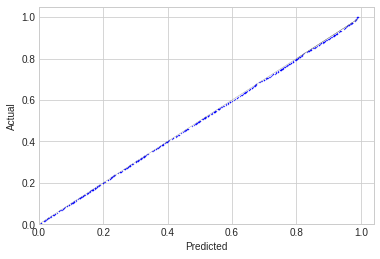

In [ ]:
handler = Butterfly(50000)
test_df = handler.test(X_test, Y_test)[0]
handler.graph_results(test_df, num=500)